# A2C for text plagiarism detection

In [1]:
import random
from itertools import accumulate

import matplotlib.pyplot as plt
import numpy as np
import scipy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
from tqdm import tqdm

In [2]:
torch.cuda.is_available()

True

In [3]:
# DEVICE = torch.device("cuda") or torch.device("cpu")
DEVICE = torch.device("cpu")
DEVICE

device(type='cpu')

## Utilities

In [4]:
GAMMA = 0.99
REWARD_STEPS = 4

In [5]:
def calculate_qvals(
    rewards: list[float], gamma: float = GAMMA, reward_steps: int = REWARD_STEPS
) -> np.ndarray:
    qvals = []

    rw_steps = reward_steps if reward_steps != 0 else len(rewards)

    for i in range(len(rewards)):
        qvals.append(
            list(
                accumulate(
                    reversed(rewards[i : i + rw_steps]), lambda x, y: gamma * x + y
                )
            )[-1]
        )
    return np.array(qvals)

## Dataset

In [6]:
tokenizer = get_tokenizer("basic_english")
global_vectors = GloVe(cache="../data")

data = [
    ("hello, world!", "hi world", 1.0),
    ("hello, world!", "cat eats beetle", 0.0),
    ("sky is blue", "horizon is not red", 0.5),
    ("sky is red", "horizon is not blue", 0.5),
]

In [13]:
def text_pipeline(x):
    return global_vectors.get_vecs_by_tokens(tokenizer(x), lower_case_backup=True)


class PlagiarismDataset(Dataset):
    def __init__(self, data: list[tuple[str, str, int]]):
        targets, candidates, scores = [], [], []

        for target, candidate, score in data:
            targets.append(text_pipeline(target))
            candidates.append(text_pipeline(candidate))
            scores.append(score)

        self.targets = targets
        self.candidates = candidates
        self.scores = np.array(scores).astype(np.float16)

    def __len__(self):
        return len(self.scores)

    def __getitem__(self, idx):
        # if torch.is_tensor(idx):
        #     idx = idx.tolist()
        return (
            self.targets[idx].to(DEVICE),
            self.candidates[idx].to(DEVICE),
            torch.tensor([self.scores[idx]]).float().to(DEVICE),
        )

In [15]:
dataset = PlagiarismDataset(data)
print(len(dataset))
# print(dataset[0])

4


In [16]:
EMBED_DIM = global_vectors.dim
LSTM_LAYERS = 2
HIDDEN_SIZE = EMBED_DIM

## Environment

In [54]:
class Env:
    def _get_state(self) -> torch.Tensor:
        token = self.data[self.sentence_idx][self.token_idx]
        return torch.cat(
            [
                self.hs[self.sentence_idx].flatten(),
                self.cs[self.sentence_idx].flatten(),
                token,
            ]
        ).to(DEVICE)

    def _get_reward(self) -> float:
        if not self.is_terminal():
            return 0.0

        cnet_out = self.cnet(self.hs.view(1, -1))

        score_tensor = torch.FloatTensor([self.data[2]]).to(DEVICE)
        loss = self.loss_fn(cnet_out.squeeze(-1), score_tensor)

        return -np.log(loss.item() + 1e-8) + self.gamma * self.deleted / self.total_words

    def __init__(
        self,
        dataset: Dataset,
        lstm: nn.Module,
        cnet: nn.Module,
        loss_fn,
        gamma: float = 0.05,
    ) -> None:
        self.lstm = lstm
        self.cnet = cnet

        self.loss_fn = loss_fn

        self.gamma = gamma

        self.dataset = dataset

        self.reset()

    def reset(self) -> torch.Tensor:
        self.steps = 0

        self.sentence_idx = 0
        self.token_idx = 0

        idx = np.random.randint(len(self.dataset))
        self.data = self.dataset[idx]

        self.total_words = len(self.data[0]) + len(self.data[1])
        self.deleted = 0

        self.hs = torch.zeros((2, LSTM_LAYERS, HIDDEN_SIZE)).to(DEVICE)
        self.cs = torch.zeros((2, LSTM_LAYERS, HIDDEN_SIZE)).to(DEVICE)

        return self.get_state()

    def get_state(self) -> torch.Tensor:
        return self._get_state()

    def is_terminal(self) -> bool:
        return self.sentence_idx == 1 and self.token_idx == (len(self.data[1]) - 1)

    def interact(self, action: int) -> tuple[list[int], float, bool]:
        # 0 - retain
        # 1 - delete

        # print(self.sentence_idx, self.token_idx)

        if self.is_terminal():
            return self._get_state(), 0, self.is_terminal()

        if action == 1:
            self.deleted += 1

        elif action == 0:
            token = self.data[self.sentence_idx][self.token_idx]
            _, (h, c) = self.lstm(token.view(1, -1))
            self.hs[self.sentence_idx] = h.clone().detach().requires_grad_(True)
            self.cs[self.sentence_idx] = c.clone().detach().requires_grad_(True)

        self.steps += 1
        self.token_idx += 1
        if self.sentence_idx == 0 and self.token_idx >= len(self.data[0]):
            self.sentence_idx = 1
            self.token_idx = 0

        return self._get_state(), self._get_reward(), self.is_terminal()

    def get_observation_shape(self) -> int:
        return 2 * LSTM_LAYERS * HIDDEN_SIZE + EMBED_DIM

    def get_actions_shape(self) -> int:
        return 2

In [55]:
# test_env = Env()
# print(test_env.interact(2))
# print(test_env.interact(1))
# print(test_env.interact(0))
# print(test_env.is_terminal())

## Policy Gradient Network

In [56]:
class A2CNet(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 16) -> None:
        super(A2CNet, self).__init__()

        self.body = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
        )

        self.policy = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
        )

        self.value = nn.Sequential(
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        body_out = self.body(x)
        return self.policy(body_out), self.value(body_out)

## Agent

In [57]:
action_logits = torch.FloatTensor([1, 2, 3])
print(F.softmax(action_logits, dim=0))
random.choices(range(len(action_logits)), F.softmax(action_logits, dim=0))[0]

tensor([0.0900, 0.2447, 0.6652])


2

In [58]:
class Agent:
    def choose_action(self, action_logits):
        return random.choices(range(len(action_logits)), F.softmax(action_logits, dim=0))[
            0
        ]

## Trajectory Buffer

In [59]:
class TrajectoryBuffer:
    """
    Buffer class to store the experience from a unique policy
    """

    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.discounted_rewards = []
        self.terminal_states = []

    def store(self, states_trajectory: np.ndarray, trajectory: np.ndarray):
        """
        Add trajectory values to the buffers and compute the advantage and reward to go

        Parameters:
        -----------
        states_trajectory:  list that contains states
        trajectory: list where each element is a list that contains: reward, action
        """
        assert len(states_trajectory) == len(trajectory)

        if len(states_trajectory) > 0:
            self.states.extend(states_trajectory)
            self.rewards.extend(trajectory[:, 0])
            self.actions.extend(trajectory[:, 1])
            discounted_rewards = calculate_qvals(trajectory[:, 0])

            self.discounted_rewards.extend(discounted_rewards)

    def get_batch(self):
        return self.states, self.actions, self.discounted_rewards

    def __len__(self):
        assert len(self.states) == len(self.actions) == len(self.discounted_rewards)
        return len(self.states)

## Training

In [60]:
class CNet(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, hidden_dim: int = 16) -> None:
        super(CNet, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.net(x)


lstm = nn.LSTM(EMBED_DIM, HIDDEN_SIZE, num_layers=LSTM_LAYERS, bidirectional=False).to(
    DEVICE
)
cnet = CNet(2 * LSTM_LAYERS * HIDDEN_SIZE, 1).to(DEVICE)
loss_fn = F.mse_loss

In [61]:
LEARNING_RATE = 0.005

np.random.seed(42)
torch.manual_seed(42)

env = Env(dataset, lstm, cnet, loss_fn)
net = A2CNet(
    input_dim=env.get_observation_shape(), output_dim=env.get_actions_shape()
).to(DEVICE)
agent = Agent()
optimizer = optim.Adam(
    net.parameters(),
    lr=LEARNING_RATE,
    # eps=1e-3
)

In [76]:
# EPOCHS = 4000
EPOCHS = 5
EPISODES_PER_EPOCH = 10

ENTROPY_BETA = 0.01
CLIP_GRAD = 0.1

In [77]:
step_count = 0
train_rewards = []
train_ep_len = []

mean_epoch_rewards = []
mean_epoch_ep_len = []
epoch_loss = []
epoch_entropy = []

probs = []

loop = tqdm(range(EPOCHS), desc="Epoch")

for _ in loop:
    state = env.reset()
    buffer = TrajectoryBuffer()
    env_states_buf, env_rew_act_buf = [], []
    ep_rewards = []

    train_logs_shift = len(train_rewards)  # for logging

    done_episodes = 0
    # while len(buffer) < STEPS_PER_EPOCH:
    while done_episodes < EPISODES_PER_EPOCH:
        with torch.no_grad():
            action_logits = net(state)[0]

        action = agent.choose_action(action_logits)
        state2, reward, done = env.interact(action)

        env_states_buf.append(state.clone().detach().numpy())
        env_rew_act_buf.append([reward, int(action)])

        state = state2.clone().detach()

        step_count += 1
        ep_rewards.append(reward)

        if done:
            buffer.store(np.array(env_states_buf), np.array(env_rew_act_buf))
            env_states_buf, env_rew_act_buf = [], []

            train_rewards.append(np.sum(ep_rewards))
            train_ep_len.append(len(ep_rewards))

            state = env.reset()
            ep_rewards = []

            done_episodes += 1

    state_batch, action_batch, reward_batch = buffer.get_batch()

    optimizer.zero_grad()
    states_t = torch.FloatTensor(np.array(state_batch)).to(DEVICE)
    batch_actions_t = torch.LongTensor(action_batch).to(DEVICE)
    batch_cum_rewards_t = torch.FloatTensor(reward_batch).to(DEVICE)

    logits_v, value_v = net(states_t)

    # Value loss
    loss_value_v = F.mse_loss(value_v.squeeze(-1), batch_cum_rewards_t)

    # Policy loss
    log_prob_v = F.log_softmax(logits_v, dim=1)
    adv_v = batch_cum_rewards_t - value_v.detach()
    log_prob_actions_v = adv_v * log_prob_v[range(len(states_t)), batch_actions_t]
    loss_policy_v = -log_prob_actions_v.mean()

    # Entropy loss
    prob_v = F.softmax(logits_v, dim=1)
    entropy_v = (prob_v * log_prob_v).sum(dim=1).mean()
    entropy_loss_v = ENTROPY_BETA * entropy_v

    # Policy backward
    loss_policy_v.backward(retain_graph=True)
    # for logging stuff TBD

    # Value backward
    loss_v = entropy_loss_v + loss_value_v
    loss_v.backward()

    nn.utils.clip_grad_norm_(net.parameters(), CLIP_GRAD)
    optimizer.step()
    loss_v += loss_policy_v

    # logging
    probs.append(prob_v.detach().cpu().numpy())
    mean_epoch_rewards.append(np.mean(train_rewards[train_logs_shift:]))
    mean_epoch_ep_len.append(np.mean(train_ep_len[train_logs_shift:]))
    # epoch_loss.append(loss_v.item())
    epoch_loss.append(loss_v.item())
    epoch_entropy.append(-entropy_v.item())

    loop.set_postfix(
        {
            "Mean reward": mean_epoch_rewards[-1],
            "Mean ep len": mean_epoch_ep_len[-1],
            "Mean Loss": epoch_loss[-1],
            "Mean Entropy": epoch_entropy[-1],
        }
    )
    # if epoch_loss[-1] < 0:
    #     print(loss_v.item())
    #     break

Epoch: 100%|██████████| 5/5 [00:00<00:00,  5.64it/s, Mean reward=4.06, Mean ep len=5.8, Mean Loss=16, Mean Entropy=0.651]  


In [78]:
np.max(mean_epoch_rewards)

8.07916712674769

In [79]:
def get_uniform_entropy(n_actions: int):
    probs = np.array([1 / n_actions for _ in range(n_actions)])
    return -np.sum(probs * np.log(probs))


uniform_entropy = get_uniform_entropy(env.get_actions_shape())
uniform_entropy

0.6931471805599453

In [83]:
def moving_average(x, w=min(50, EPOCHS)):
    # return np.convolve(x, np.ones(w), 'same') / w
    return scipy.signal.savgol_filter(x, w, min(3, w - 1))


moving_average([1, 2, 3, 4], 2)

array([1. , 2.5, 3.5, 4. ])

[]

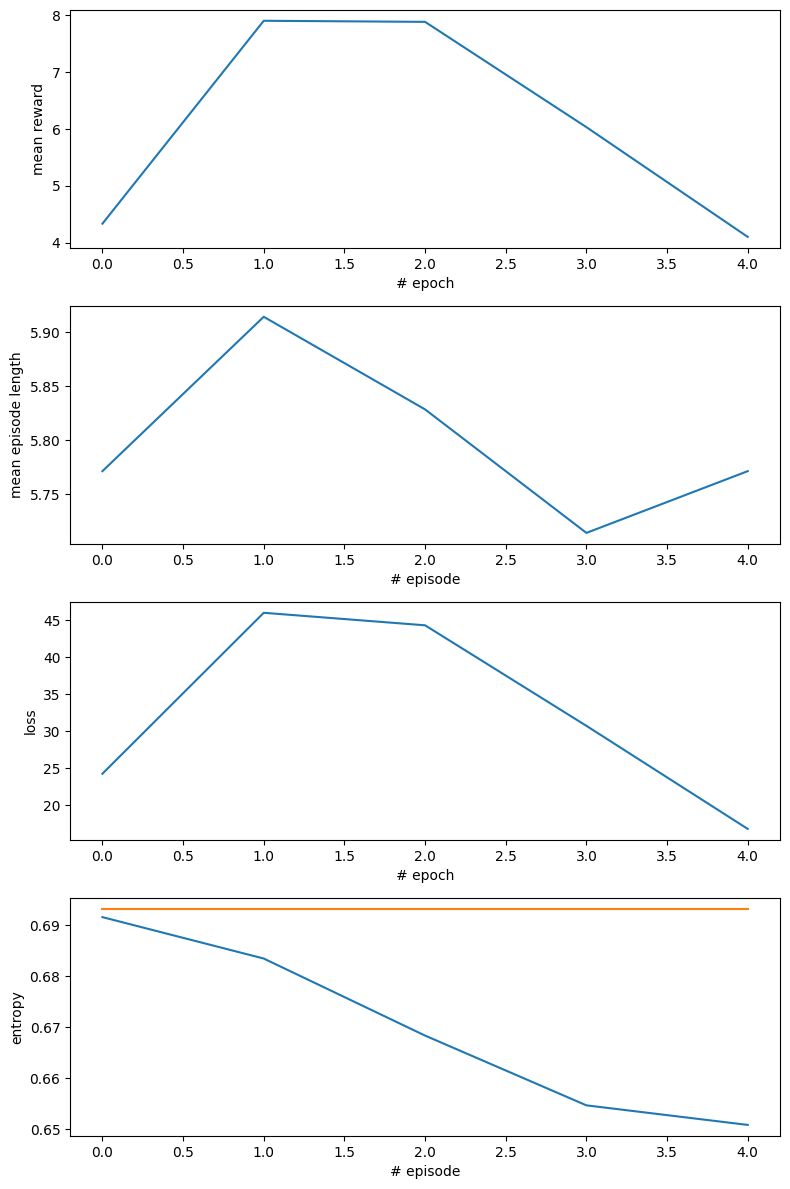

In [84]:
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

# Mean Reward per epoch

axs[0].plot(range(EPOCHS), moving_average(mean_epoch_rewards))
# axs[0].plot(range(EPOCHS), [98] * EPOCHS)  # optimal value
# axs[0].plot(range(EPOCHS), [85] * EPOCHS)  # suboptimal value
axs[0].set_xlabel("# epoch")
axs[0].set_ylabel("mean reward")

# Mean Episode length per epoch
axs[1].plot(range(EPOCHS), moving_average(mean_epoch_ep_len))
axs[1].set_xlabel("# episode")
axs[1].set_ylabel("mean episode length")


# Epoch loss
axs[2].plot(range(EPOCHS), moving_average(epoch_loss))
axs[2].set_xlabel("# epoch")
axs[2].set_ylabel("loss")

# Epoch entropy
axs[3].plot(range(EPOCHS), moving_average(epoch_entropy))
axs[3].plot(range(EPOCHS), [uniform_entropy] * EPOCHS)
axs[3].set_xlabel("# episode")
axs[3].set_ylabel("entropy")

plt.tight_layout()
plt.plot()